In [1]:
cd /home/tkim/Academics/EdgeAlloc/

/home/tkim/Academics/EdgeAlloc


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

# Import tools
import tools.solver_utils as ts
import tools.other_utils as to
import tools.sim_utils as tm

# Import classes
from classes.User import *
from classes.Server import *

import pdb

In [9]:
# testing user markov chain 
U = 10
K = 9
T = 10000

space_1d_dim = 10
num_locs = 9
cap_multiply = 10

# Generate visitng locations and server locations
usr_locs = tm.gen_eq_locs(space_1d=space_1d_dim, nums=num_locs, offset = 1.7)
svr_locs = tm.gen_eq_locs(space_1d=space_1d_dim, nums=K, offset = 1.7)
C = np.ones(K) * cap_multiply

mu = np.random.uniform(low=0.0, high=1.0, size=[U,K])

servers = []
for s in range(len(svr_locs)):
    servers += [Server(C[s], s, mu, svr_locs[s])]

users = []
for i in range(U):
    users += [User(servers, T, usr_locs, lat_dist = 4.5, self_weight = 0.75, threshold_dist=3.5)]
    
regret_dist = np.zeros(T)

# Central solver
UCB = np.ones_like(mu)
T_ka = np.ones_like(mu)
rewards_sum = np.ones([U,K]) # Just for calculating UCB idx
regret_central = np.zeros(T)

# pbar = tqdm(total=T)
pbar = tqdm(total=T - K)

for t in range(T - K):
    
    # Obtain New Arm availability
    L = to.obtain_L_users(U,K,users)
    
    # Optimal placement and reward
    opt_x, opt_reward = ts.solve_optimization(mu, C, L)
    
    # Solve for Central
    lrn_x, _ = ts.solve_optimization(UCB, C, L)
    lrn_reward = ts.calculate_obj_val(lrn_x, mu, C)
    regret_central[t] = opt_reward - lrn_reward
    UCB, T_ka, rewards_sum, mu_bar = ts.play_UCB(UCB, T_ka, rewards_sum, t+1, mu, lrn_x)
    
    # Solve Naive - Distributed 
    lrn_x_dist = tm.dist_usr_arms(users)
    lrn_reward_dist = ts.calculate_obj_val(lrn_x_dist, mu, C)
    regret_dist[t] = opt_reward - lrn_reward_dist
    tm.dist_receive_rewards(servers, users, lrn_x_dist)
    
    for u in users:
        u.next_step()
    
    pbar.update(1)
pbar.close()

100%|██████████| 9991/9991 [03:41<00:00, 45.07it/s]


Text(0.5,0,'Rounds')

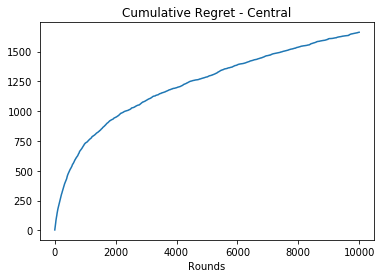

In [10]:
plt.plot(np.cumsum(regret_central))
plt.title("Cumulative Regret - Central")
plt.xlabel("Rounds")

Text(0.5,0,'Rounds')

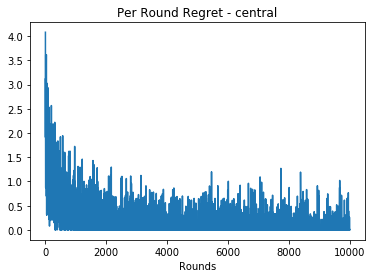

In [11]:
plt.plot(regret_central)
plt.title("Per Round Regret - central")
plt.xlabel("Rounds")

Text(0.5,0,'Rounds')

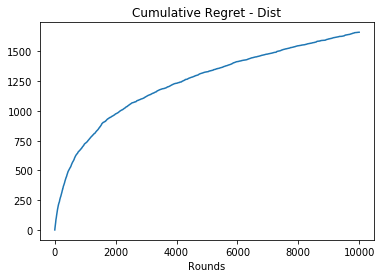

In [12]:
plt.plot(np.cumsum(regret_dist))
plt.title("Cumulative Regret - Dist")
plt.xlabel("Rounds")

Text(0.5,0,'Rounds')

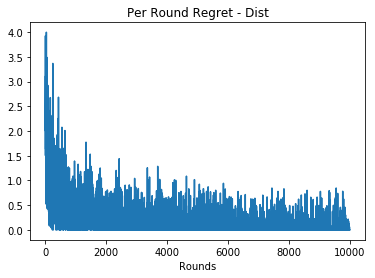

In [13]:
plt.plot(regret_dist)
plt.title("Per Round Regret - Dist")
plt.xlabel("Rounds")

In [16]:
users[0].arms_per_loc

{0: [0, 1, 3],
 1: [0, 1, 2, 4],
 2: [1, 2, 5],
 3: [0, 3, 4, 6],
 4: [1, 3, 4, 5, 7],
 5: [2, 4, 5, 8],
 6: [3, 6, 7],
 7: [4, 6, 7, 8],
 8: [5, 7, 8]}